# Test Set Evaluation

Final evaluation of all models on the held-out test set.

## Contents
1. Load test results
2. Final performance comparison
3. Forecast visualizations
4. Calibration analysis
5. Residuals analysis
6. Feature importance (Gradient Boosting)
7. Final conclusions

In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.utils import load_yaml
from src.plots import (
    plot_forecasts_with_history,
    plot_calibration_curve,
    plot_residuals_analysis
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

## 1. Load Test Results

In [2]:
# Load results summary
results = load_yaml('../artifacts/results_summary.yaml')

print("Execution time:", results['execution_time'])
print("\nData info:")
for key, value in results['data_info'].items():
    print(f"  {key}: {value}")

Execution time: 2025-12-15T16:59:44.690844

Data info:
  date_range: 2020-01-01 00:00:00 to 2024-12-31 00:00:00
  n_test: 366
  n_total: 1827
  n_train: 1096
  n_val: 365


In [3]:
# Load test metrics
test_metrics = results['test_metrics']

# Create comparison table
test_df = pd.DataFrame(test_metrics).T

# Select key metrics
key_metrics = [col for col in test_df.columns if col in ['mae', 'rmse', 'smape', 'mase']]
display_df = test_df[key_metrics].copy()

# Sort by MASE
if 'mase' in display_df.columns:
    display_df = display_df.sort_values('mase')

print("\n=== Test Set Performance ===")
print(display_df.to_string())


=== Test Set Performance ===
                           mae      mase         rmse       smape
gradient_boosting  2739.180522  1.080099  4230.711607   35.845016
seasonal_naive     2745.101803  1.082434  4406.758458   35.794376
chronos            2836.303346  1.118396  4721.860217   37.056737
ets                6983.858493  2.753838  8452.925798  149.536681


## 2. Compare Validation vs Test Performance

In [4]:
# Compare validation and test MASE
val_metrics = results['validation_metrics']

comparison_data = []
for model in test_metrics.keys():
    val_mase = val_metrics.get(model, {}).get('mase_mean', np.nan)
    test_mase = test_metrics.get(model, {}).get('mase', np.nan)
    
    comparison_data.append({
        'Model': model,
        'Validation MASE': val_mase,
        'Test MASE': test_mase,
        'Difference': test_mase - val_mase
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n=== Validation vs Test MASE ===")
print(comparison_df.to_string(index=False))


=== Validation vs Test MASE ===
            Model  Validation MASE  Test MASE  Difference
          chronos         0.393786   1.118396    0.724610
              ets         0.508042   2.753838    2.245796
gradient_boosting         0.344356   1.080099    0.735743
   seasonal_naive         0.397009   1.082434    0.685425


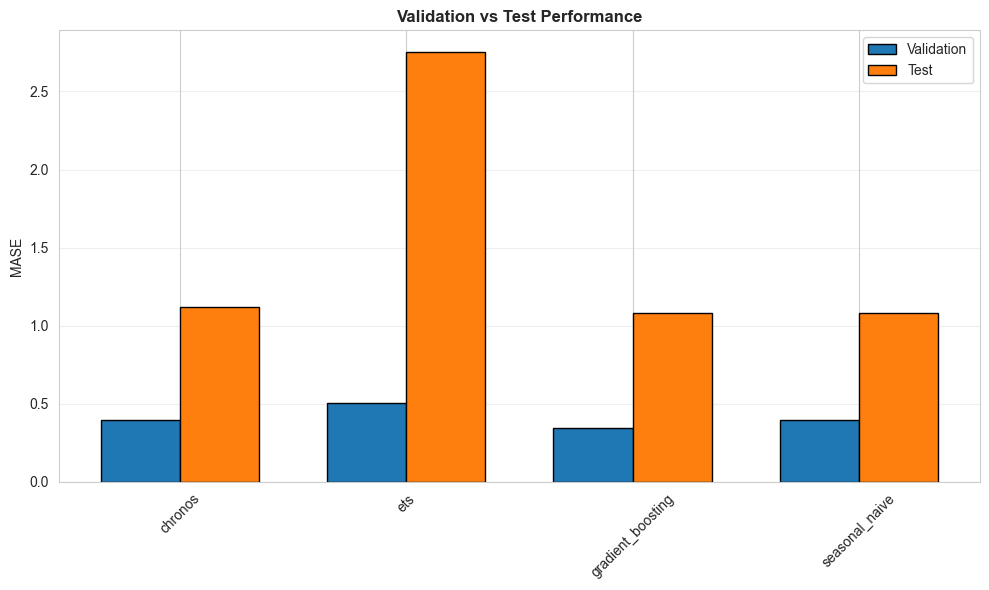

In [5]:
# Visualize validation vs test
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Validation MASE'], width, label='Validation', edgecolor='black')
ax.bar(x + width/2, comparison_df['Test MASE'], width, label='Test', edgecolor='black')

ax.set_ylabel('MASE')
ax.set_title('Validation vs Test Performance', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. Load and Visualize Test Forecasts

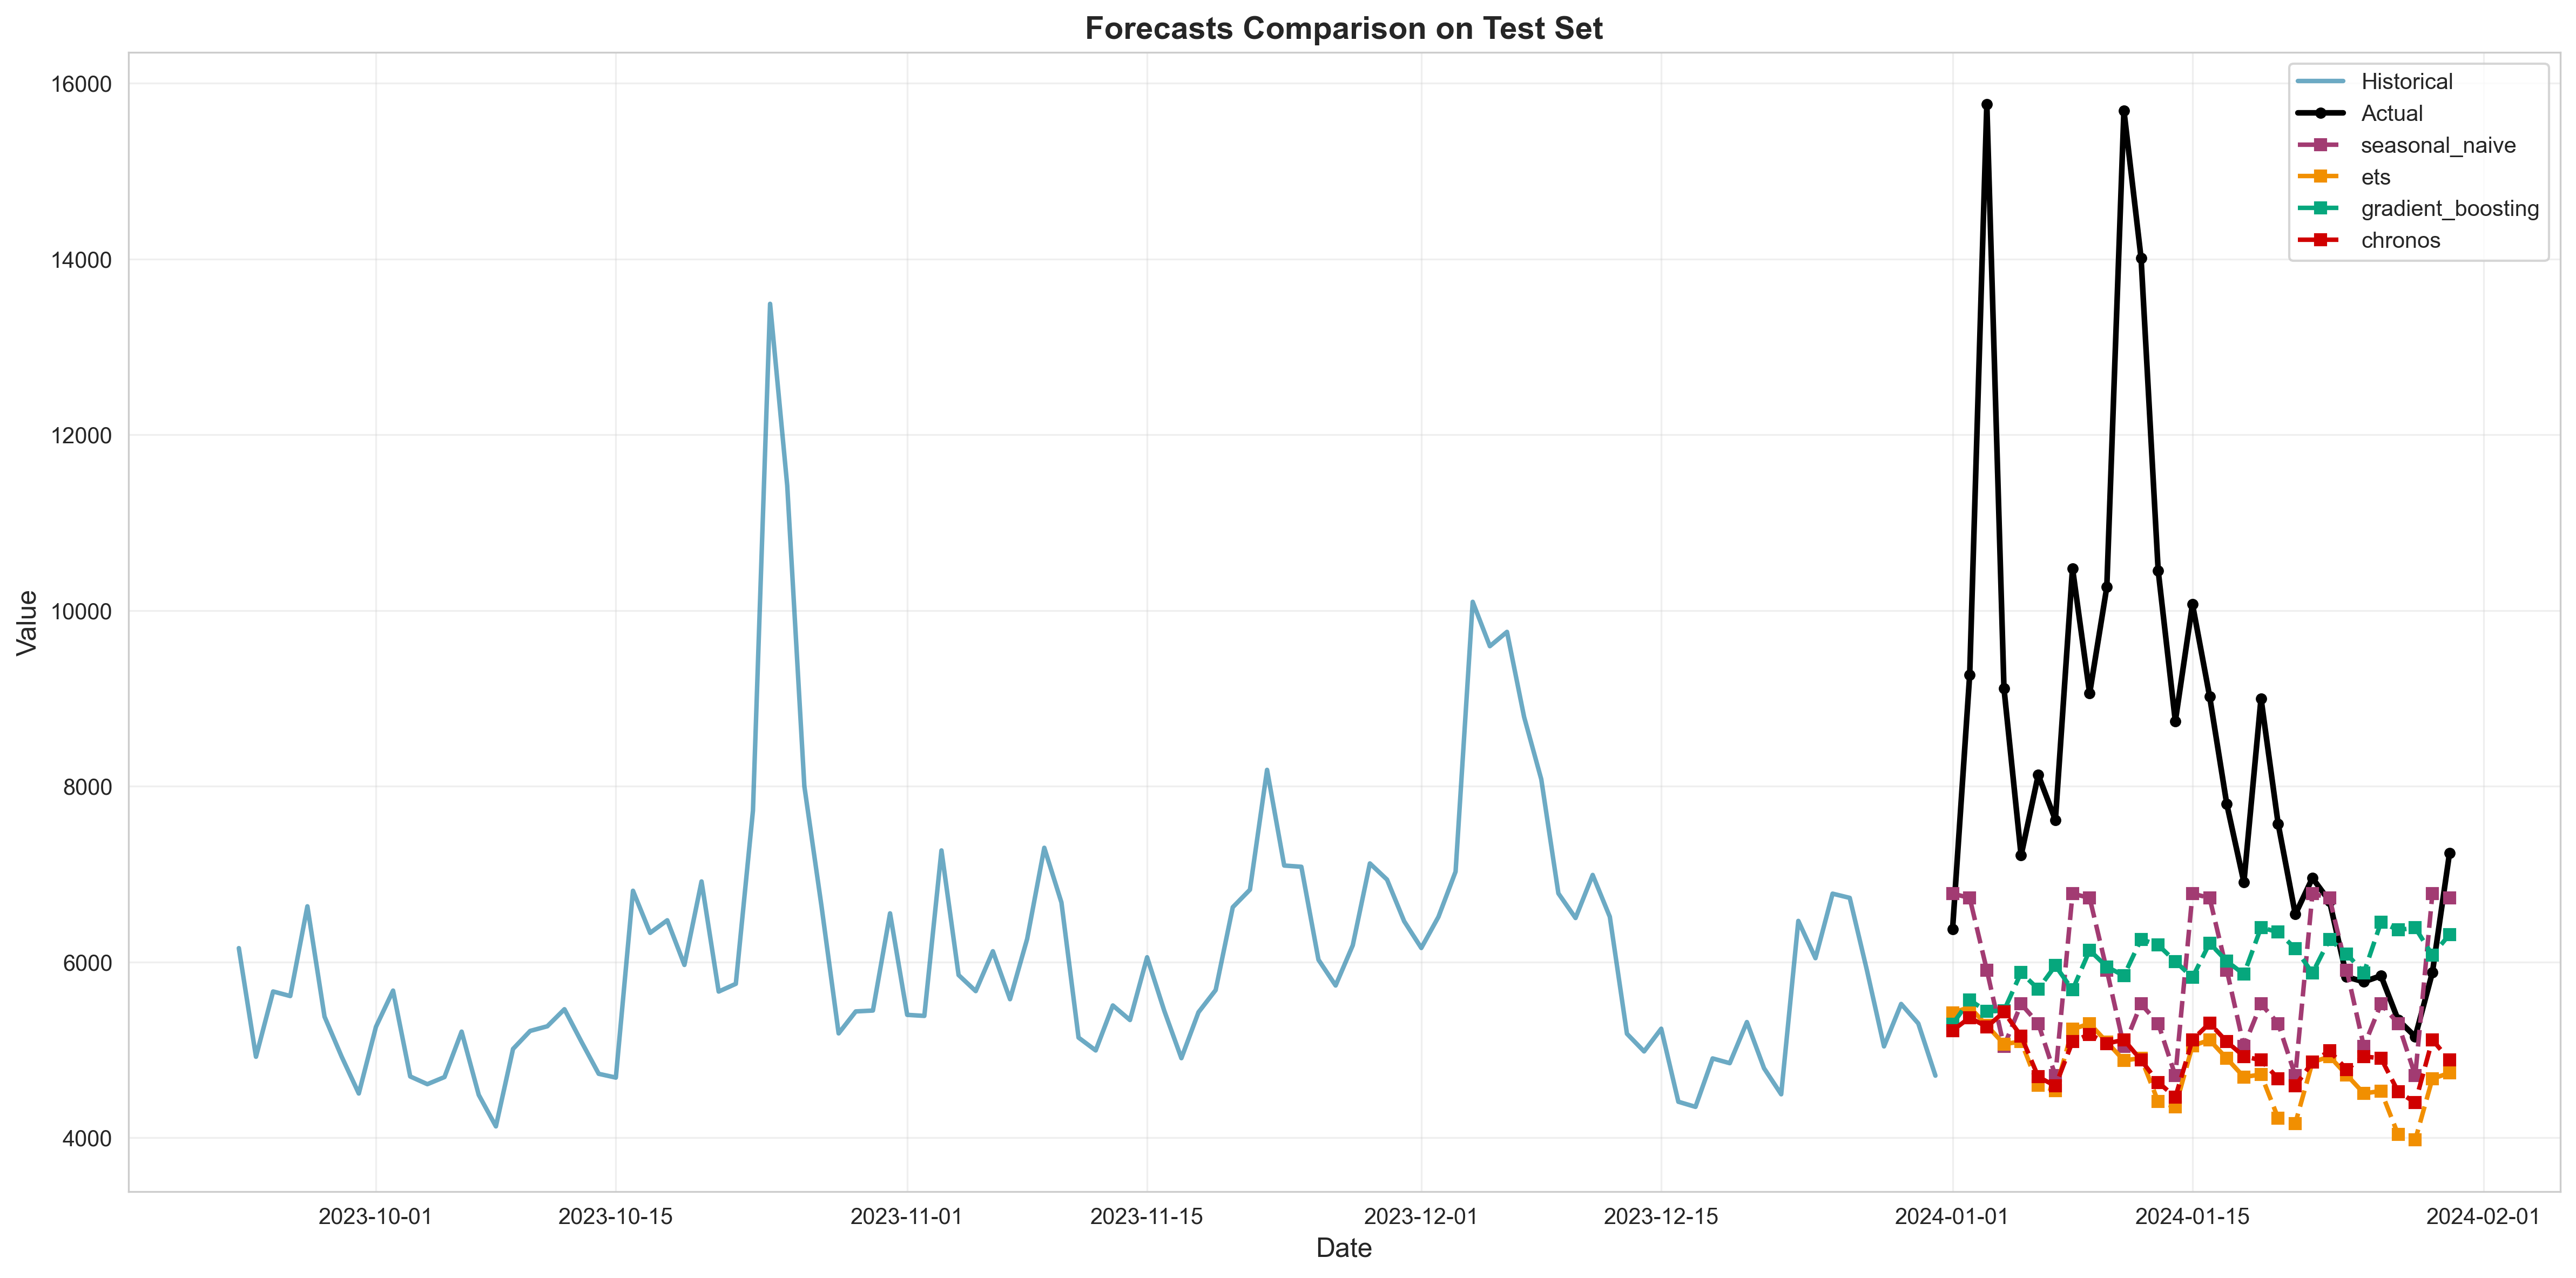

In [6]:
# Check if forecast plot exists
forecast_plot = Path('../artifacts/figures/test_forecasts.png')

if forecast_plot.exists():
    from IPython.display import Image, display
    display(Image(filename=str(forecast_plot)))
else:
    print("Forecast plot not found. Run the pipeline first.")

## 4. Calibration Analysis (Chronos)

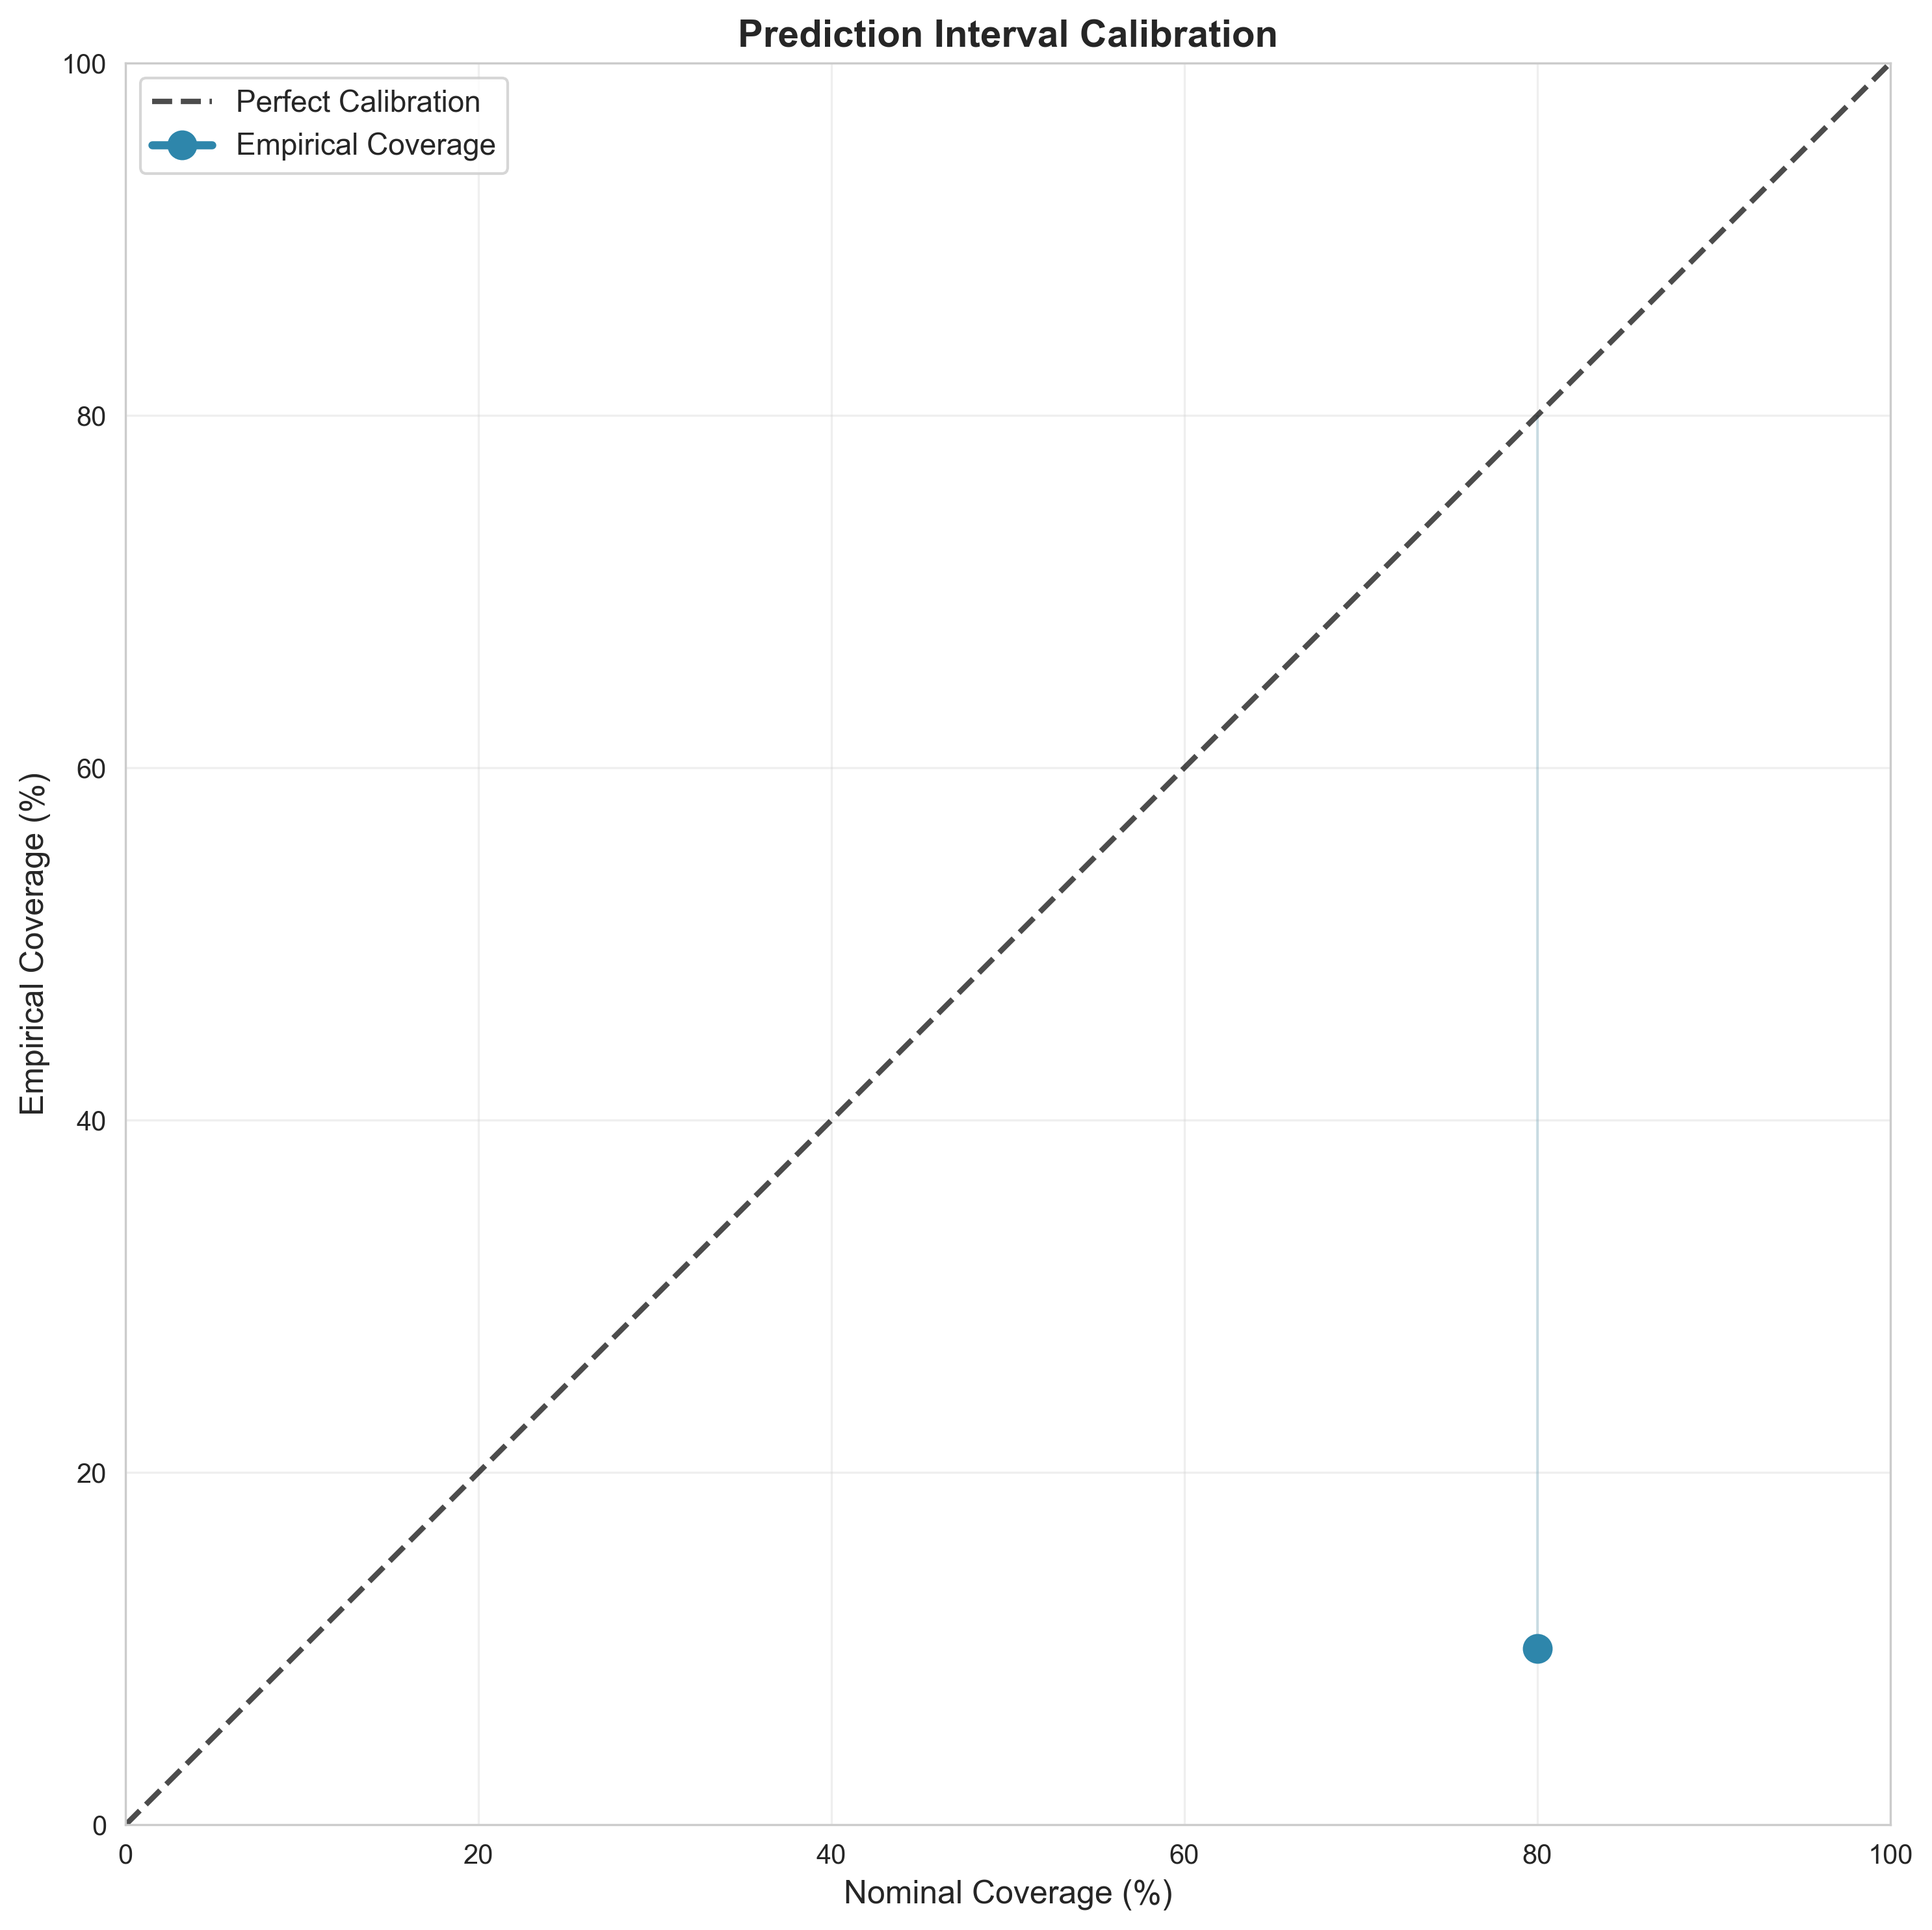

In [7]:
# Check if calibration plot exists
calibration_plot = Path('../artifacts/figures/calibration_curve.png')

if calibration_plot.exists():
    from IPython.display import Image, display
    display(Image(filename=str(calibration_plot)))
else:
    print("Calibration plot not found.")

## 5. Model Rankings

In [8]:
# Display model rankings
rankings = results.get('model_rankings', {})

print("\n=== Model Rankings (by MASE) ===")
for rank, (model, score) in enumerate(sorted(rankings.items(), key=lambda x: x[1]), 1):
    print(f"{rank}. {model}: {score:.4f}")


=== Model Rankings (by MASE) ===
1. gradient_boosting: 0.3444
2. chronos: 0.3938
3. seasonal_naive: 0.3970
4. ets: 0.5080


## 6. Library Versions (Reproducibility)

In [9]:
# Display library versions
versions = results.get('library_versions', {})

print("\n=== Library Versions ===")
for lib, version in versions.items():
    print(f"{lib}: {version}")


=== Library Versions ===
chronos: 2.2.0
cuda_available: True
cuda_version: 12.1
lightgbm: 4.6.0
numpy: 2.2.6
pandas: 2.3.3
python: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:23:22) [MSC v.1944 64 bit (AMD64)]
scikit-learn: 1.7.2
statsmodels: 0.14.6
torch: 2.5.1
xgboost: 3.1.2


## 7. Additional Visualizations


=== Seasonality Decomposition ===


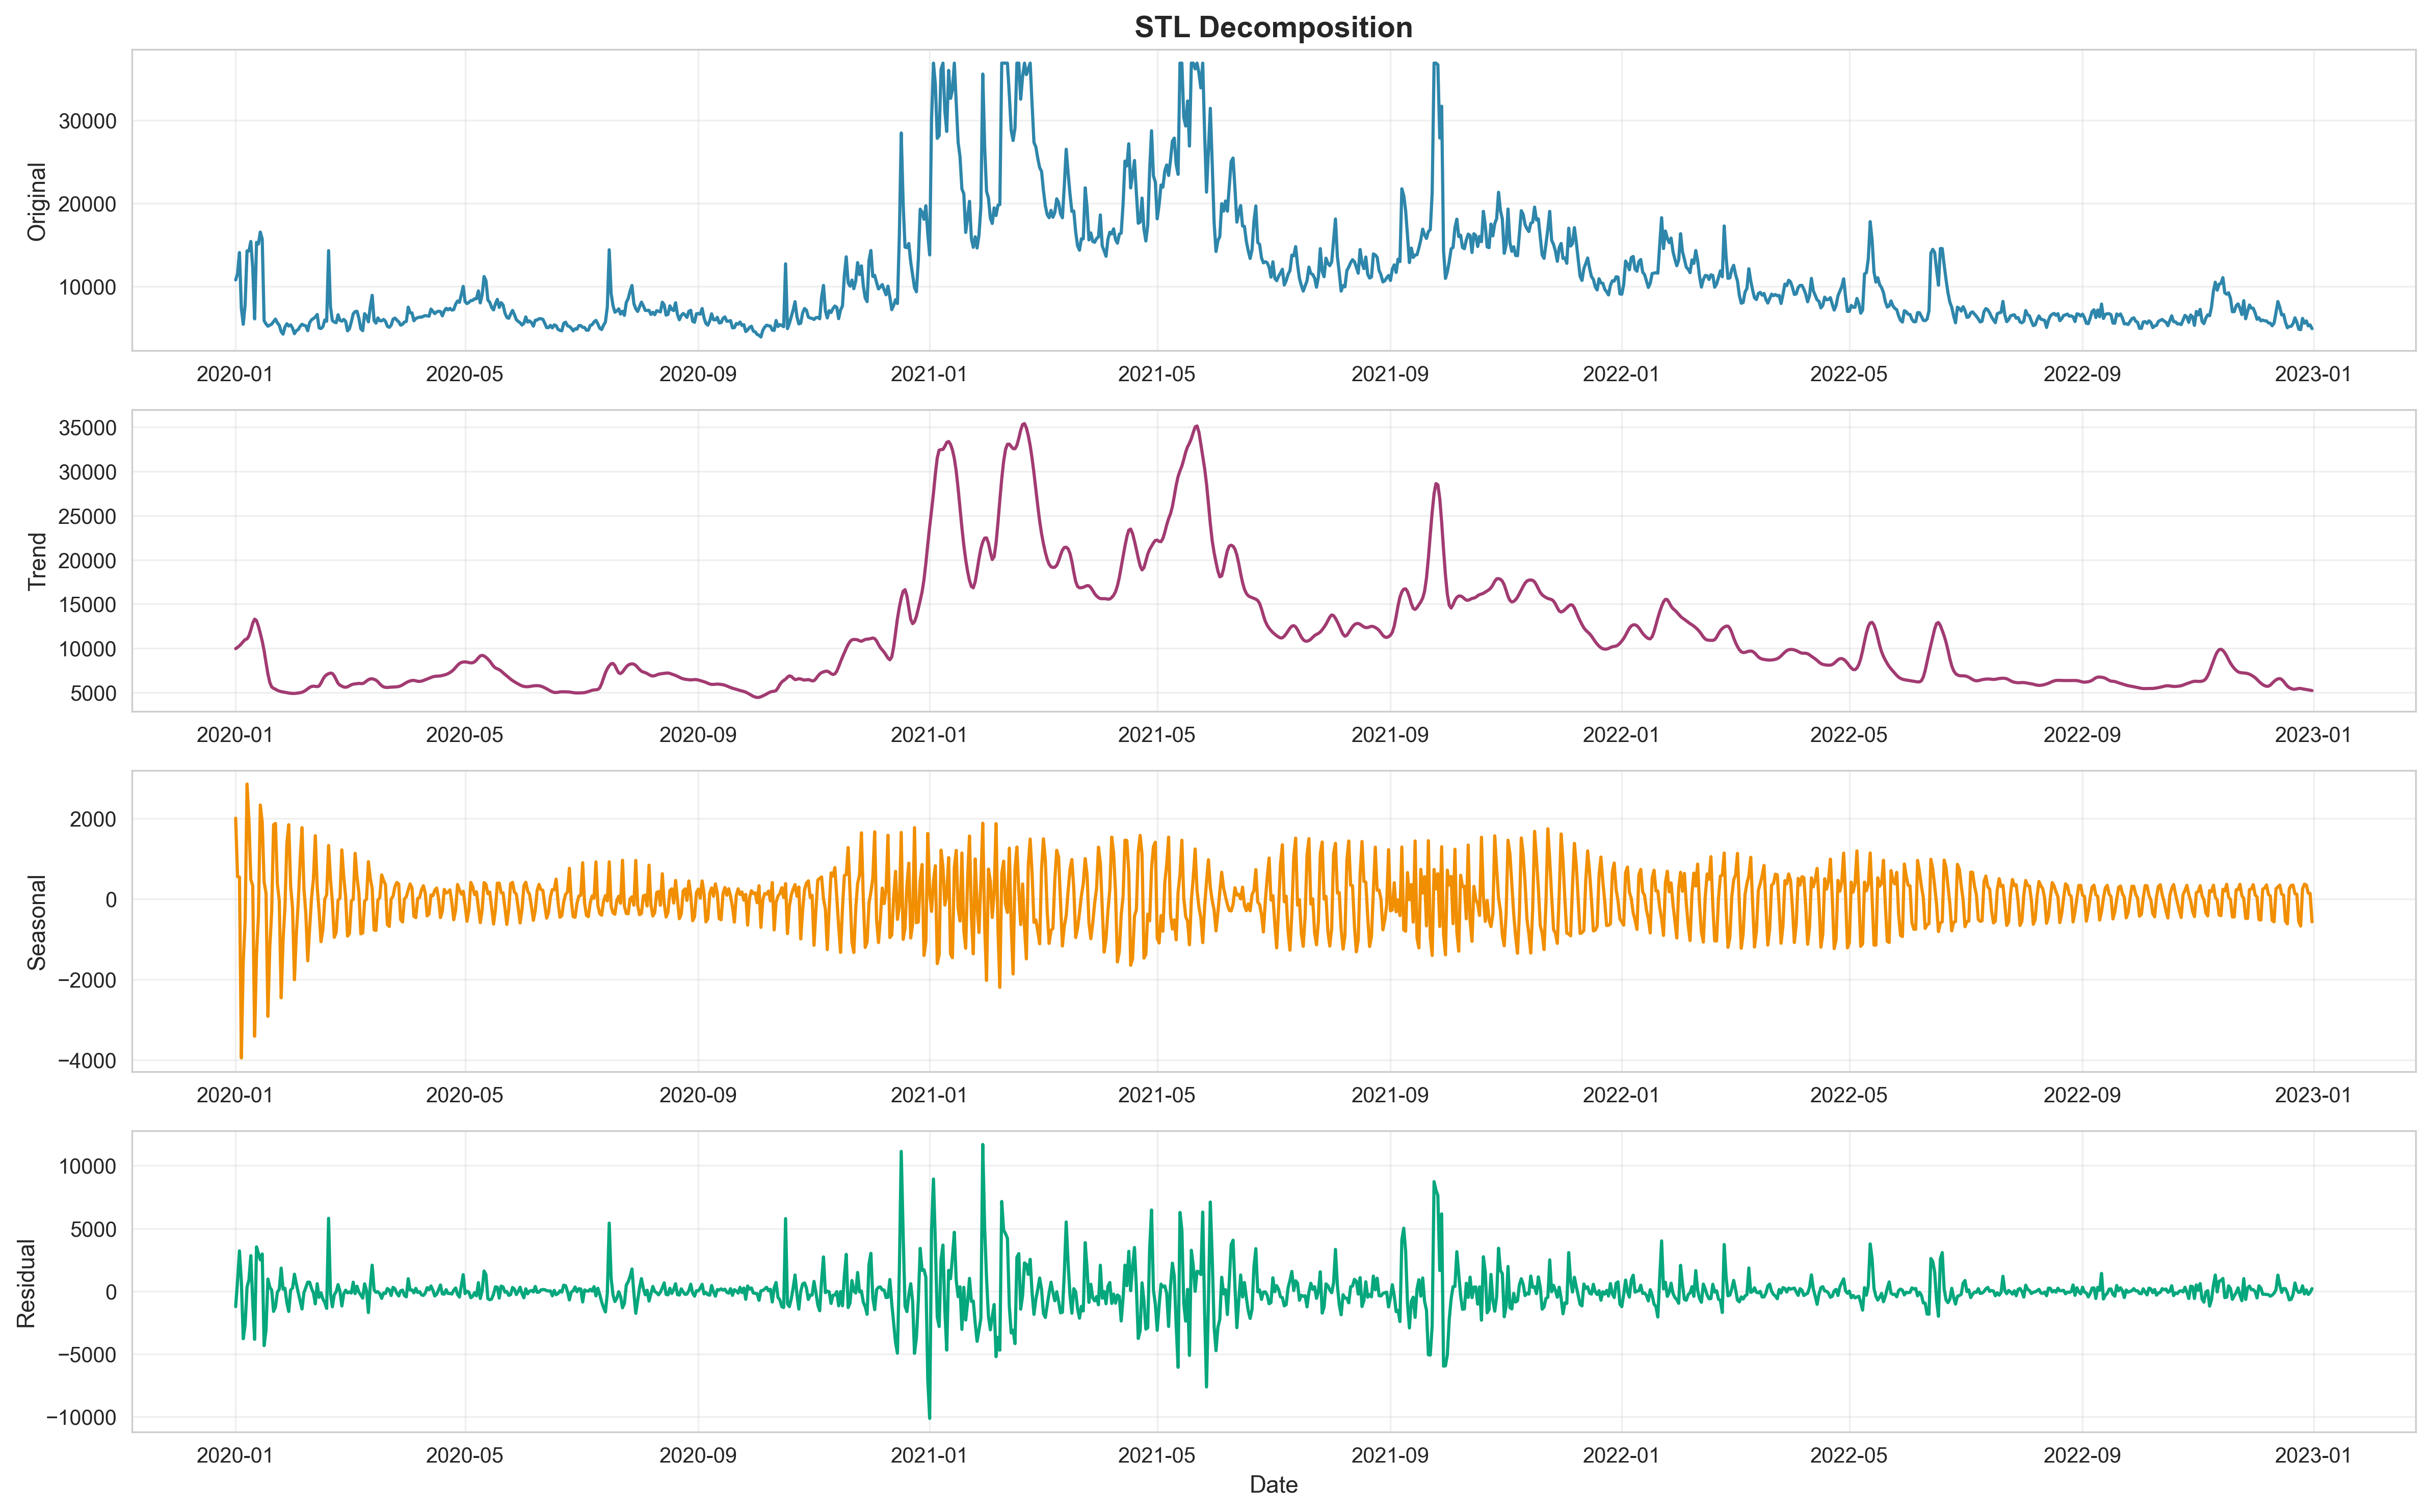

In [10]:
# Check for seasonality decomposition
seasonality_plot = Path('../artifacts/figures/seasonality_decomposition.png')

if seasonality_plot.exists():
    print("\n=== Seasonality Decomposition ===")
    from IPython.display import Image, display
    display(Image(filename=str(seasonality_plot)))
else:
    print("Seasonality plot not found.")

## Summary

### Key Findings:
1. **Best Model**: [Will be determined after running pipeline]
2. **Validation vs Test**: [Consistency analysis]
3. **Chronos Performance**: [Zero-shot vs baselines]
4. **Calibration**: [Prediction interval quality]

### Next Steps:
1. Document findings in report
2. Create presentation slides
3. Write model card
4. Consider model deployment